# Check Dataset
## Pickleデータ

In [1]:
import pickle
import pandas as pd
def pickle_dump(obj, path):
    with open(path, mode='wb') as f:
        pickle.dump(obj,f)
def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data

In [17]:
path="/home/akito/Documents/Datasets/pickle_files/with_flare/sharp_dfs.pickle"
sharp_dfs=pickle_load(path)

In [55]:
sharp_dfs[int("10")]

,harpnum,totusjh,totusjz,absnjzh,savncpp,usflux,area_acr,meangam,meangbt,meangbz,...,totbsq,totfz,epsz,totfy,totfx,epsy,epsx,C_contents,M_contents,X_contents
2010-05-03 00:00:00,10,57.896,1234904000000.0,34.578,1096575000000.0,2.965962e+20,11.704288,63.111,129.763,128.192,...,1083100000.0,141.57,0.2479,185.21,149.31,-0.1622,-0.1307,0,0,0
2010-05-03 01:00:00,10,74.182,1657409000000.0,30.255,249045400000.0,4.954178e+20,24.122589,59.877,112.342,114.592,...,1165700000.0,86.811,0.1413,193.31,155.57,-0.1573,-0.1266,0,0,0
2010-05-03 02:00:00,10,96.608,2019167000000.0,29.314,435774500000.0,6.476345e+20,35.34169,57.339,123.47,132.087,...,1330200000.0,68.437,0.0976,203.75,161.99,-0.1453,-0.1155,0,0,0
2010-05-03 03:00:00,10,125.433,2579215000000.0,15.079,383730600000.0,9.006417e+20,49.202499,57.571,114.575,117.36,...,1511900000.0,50.52,0.0634,209.48,183.96,-0.1314,-0.1154,0,0,0
2010-05-03 04:00:00,10,136.789,2955413000000.0,10.693,482340800000.0,1.193474e+21,62.626389,52.834,116.61,119.596,...,1730200000.0,-15.786,-0.0173,233.62,210.15,-0.1281,-0.1152,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-05-07 17:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-05-07 18:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-05-07 19:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-05-07 20:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
path="/home/akito/Documents/Datasets/pickle_files/with_flare/All_data.csv"
all_df = pd.read_csv(path)
all_df

/home/akito/anaconda3/envs/py3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (26,27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,harpnum,totusjh,totusjz,absnjzh,savncpp,usflux,area_acr,meangam,meangbt,...,totbsq,totfz,epsz,totfy,totfx,epsy,epsx,C_contents,M_contents,X_contents
0,2010-05-01 00:00:00,1,270.853,5.777592e+12,30.270,2.383632e+12,6.510776e+21,107.599098,28.337,66.808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
1,2010-05-01 01:00:00,1,316.165,6.081439e+12,5.010,8.021213e+11,7.361199e+21,106.967400,26.925,66.337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
2,2010-05-01 02:00:00,1,347.682,7.012156e+12,58.043,3.337758e+12,7.909655e+21,92.566971,26.979,67.214,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
3,2010-05-01 03:00:00,1,392.140,8.481706e+12,27.802,1.972685e+12,7.723257e+21,79.266113,28.151,79.630,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
4,2010-05-01 04:00:00,1,354.518,7.766049e+12,38.681,2.209957e+12,7.417460e+21,70.337738,26.815,82.078,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221701,2013-12-31 19:00:00,3563,471.359,8.542634e+12,106.965,3.868445e+12,1.096246e+22,251.330307,33.558,63.220,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
221702,2013-12-31 20:00:00,3563,457.082,7.861631e+12,108.661,3.884900e+12,1.088350e+22,232.047821,32.843,61.339,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
221703,2013-12-31 21:00:00,3563,483.304,8.808026e+12,121.848,4.889245e+12,1.073362e+22,215.849945,32.040,67.450,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
221704,2013-12-31 22:00:00,3563,492.709,8.889255e+12,113.296,4.404564e+12,1.112357e+22,215.616318,30.807,65.539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0


In [52]:
flare_df=pd.concat([all_df.iloc[:,0:2],all_df.iloc[:,26:29]],axis=1)
flare_df=flare_df.rename(columns={"Unnamed: 0":"Time"})
flare_df

,Time,harpnum,C_contents,M_contents,X_contents
0,2010-05-01 00:00:00,1,0,0,0
1,2010-05-01 01:00:00,1,0,0,0
2,2010-05-01 02:00:00,1,0,0,0
3,2010-05-01 03:00:00,1,0,0,0
4,2010-05-01 04:00:00,1,0,0,0
...,...,...,...,...,...
221701,2013-12-31 19:00:00,3563,0,0,0
221702,2013-12-31 20:00:00,3563,0,0,0
221703,2013-12-31 21:00:00,3563,0,0,0
221704,2013-12-31 22:00:00,3563,0,0,0


In [1]:
out_path="/home/akito/Documents/Datasets/pickle_files/with_flare/Flare_data.csv"
flare_df.to_csv(out_path)

NameError: name 'flare_df' is not defined

## HMI_ los


In [1]:
import sunpy.map
path ="/Users/komatsu/Documents/Dataset/HMI＿los/hmi.M_45s.20100329_090000_TAI.2.magnetogram.fits"
map=sunpy.map.Map(path)
map

ModuleNotFoundError: No module named 'sunpy'

## 欠損データの確認
ダウンロードできていなかったデータがあったことから欠損データがあることが考えられるのでサーバ側に確認してどのデータがあってどのデータがないのか確認してみる。  
本来あるべき数:3840  
実際のカウント:3828  
http://jsoc.stanford.edu/SUM8/D1326827249/S00000/

In [17]:
import pandas as pd
from datetime import datetime as dt
START = "2010-05-03"
END = "2010-05-05"
def initialize_series ():
    time_index = pd.date_range(start = START,end = END,freq ="45s")
    time_series = pd.Series([0 for i in range(len(time_index))],index = time_index)
    return time_series
time_series=initialize_series()
with open ("check_server_files.txt", "r") as f:
    datas =  f.read()
    datas = datas.split("\n")
for data in datas:
    key = data[10:29]
    key = dt.strptime(key,'%Y.%m.%d_%H:%M:%S')
    time_series[key] = 1

[key for key,value in time_series.items() if value==0]

[Timestamp('2010-05-03 00:00:00', freq='45S'),
 Timestamp('2010-05-03 12:00:00', freq='45S'),
 Timestamp('2010-05-03 19:12:00', freq='45S'),
 Timestamp('2010-05-03 21:36:00', freq='45S'),
 Timestamp('2010-05-04 00:00:00', freq='45S'),
 Timestamp('2010-05-04 02:24:00', freq='45S'),
 Timestamp('2010-05-04 04:48:00', freq='45S'),
 Timestamp('2010-05-04 07:12:00', freq='45S'),
 Timestamp('2010-05-04 09:36:00', freq='45S'),
 Timestamp('2010-05-04 12:00:00', freq='45S'),
 Timestamp('2010-05-04 14:24:00', freq='45S'),
 Timestamp('2010-05-04 16:48:00', freq='45S'),
 Timestamp('2010-05-04 19:12:00', freq='45S')]

In [3]:
path = "/home/akito/Documents/Predict_Solar_Flare_Mrcnn/coord_dfs/201005coord_df.pickle"
coord_df = pickle_load(path)
coord_df

,Polygon,C_FLARE,M_FLARE,X_FLARE
2010-05-01 00:00:00,"[[(425.0, 2914.0), (425.0, 2915.0), (424.0, 29...","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]",[]
2010-05-01 01:00:00,"[[(425.0, 2910.0), (425.0, 2911.0), (424.0, 29...","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",[]
2010-05-01 02:00:00,"[[(432.0, 2910.0), (432.0, 2911.0), (431.0, 29...","[0, 0, 0, 0]","[0, 0, 0, 0]",[]
2010-05-01 03:00:00,"[[(441.0, 2910.0), (441.0, 2911.0), (440.0, 29...","[0, 0, 0, 0]","[0, 0, 0, 0]",[]
2010-05-01 04:00:00,"[[(444.0, 2912.0), (444.0, 2913.0), (443.0, 29...","[0, 0, 0, 0]","[0, 0, 0, 0]",[]
...,...,...,...,...
2010-05-31 20:00:00,[],[],[],[]
2010-05-31 21:00:00,[],[],[],[]
2010-05-31 22:00:00,[],[],[],[]
2010-05-31 23:00:00,[],[],[],[]


In [9]:
tmp = pickle_load("/home/akito/Documents/Predict_Solar_Flare_Mrcnn/coco_pickles/201008.pickle")

OrderedDict([('descripion', 'Predicting_Solar_Flare'),
             ('version', '0.1'),
             ('year', 2020),
             ('contributor', 'Akito Komatsu'),
             ('data_created', '2020/10/01')])

Observatory,SDO
Instrument,HMI SIDE1
Detector,HMI
Measurement,hmi
Wavelength,6173.0
Observation Date,2012-01-09 13:58:10
Exposure Time,0.000000 s
Dimension,[646. 510.] pix
Coordinate System,Unknown
Scale,[0.504275 0.504275] arcsec / pix
Reference Pixel,[ 319. 1088.] pix

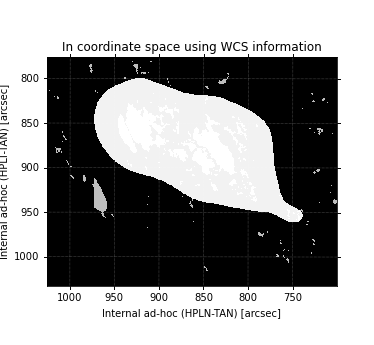
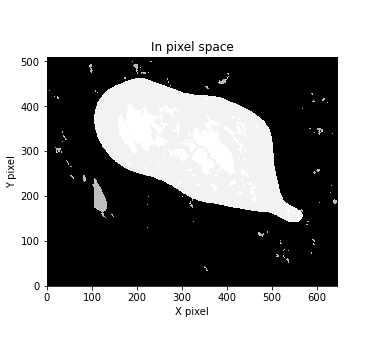
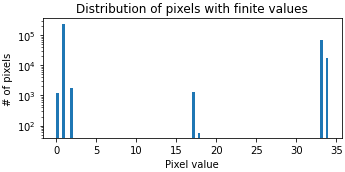

In [12]:
import sunpy.map
path = "/media/akito/Data21/hmi.Mharp_720s/2012/201201/hmi.Mharp_720s.1275.20120109_140000_TAI.bitmap.fits"
map = sunpy.map.Map(path)
map

In [8]:
path = "/home/akito/Documents/Predict_Solar_Flare_Mrcnn/coord_dfs/201005coord_df.pickle"
pickle_load(path).loc["20100511"]

,Polygon,C_FLARE,M_FLARE,X_FLARE
2010-05-11 00:00:00,"[[(3693.0, 2948.0), (3693.0, 2949.0), (3692.0,...",[0],[0],[0]
2010-05-11 01:00:00,"[[(3684.0, 2951.0), (3684.0, 2952.0), (3683.0,...",[0],[0],[0]
2010-05-11 02:00:00,"[[(3696.0, 2951.0), (3696.0, 2952.0), (3695.0,...",[0],[0],[0]
2010-05-11 03:00:00,"[[(3696.0, 2952.0), (3696.0, 2953.0), (3695.0,...",[0],[0],[0]
2010-05-11 04:00:00,"[[(3705.0, 2951.0), (3705.0, 2952.0), (3704.0,...",[0],[0],[0]
2010-05-11 05:00:00,"[[(3715.0, 2951.0), (3715.0, 2952.0), (3714.0,...",[0],[0],[0]
2010-05-11 06:00:00,"[[(3726.0, 2952.0), (3726.0, 2953.0), (3725.0,...",[0],[0],[0]
2010-05-11 07:00:00,"[[(3730.0, 2953.0), (3730.0, 2954.0), (3729.0,...",[0],[0],[0]
2010-05-11 08:00:00,"[[(3681.0, 2964.0), (3681.0, 2965.0), (3680.0,...",[0],[0],[0]
2010-05-11 09:00:00,"[[(3680.0, 2966.0), (3680.0, 2967.0), (3679.0,...",[0],[0],[0]


In [10]:
import sunpy.map
path = "/media/akito/Data/HMI_REGION/2010/201005/hmi.M_45s.20100501_000000_TAI.2.magnetogram.fits"
map = sunpy.map.Map(path)
map.data.shape

(4096, 4096)

In [17]:
import cv2
import astropy.units as u
map=sunpy.map.Map(path)
map_rotated = map.rotate(angle = -1*float(map.meta["crota2"])*u.deg)
cv2.imwrite("test.png",map_rotated.data)
map_rotated.data.shape

(4102, 4102)

In [23]:
path ="/home/akito/Documents/Predict_Solar_Flare_Mrcnn/coco_pickles/201005.pickle"
js = pickle_load(path)
js["annotations"]

 1693.0,
                1337.0,
                1694.0,
                1340.0,
                1694.0,
                1340.0,
                1695.0,
                1342.0,
                1695.0,
                1342.0,
                1696.0,
                1345.0,
                1696.0,
                1345.0,
                1697.0,
                1348.0,
                1697.0,
                1348.0,
                1698.0,
                1352.0,
                1698.0,
                1352.0,
                1699.0,
                1356.0,
                1699.0,
                1356.0,
                1700.0,
                1361.0,
                1700.0,
                1361.0,
                1701.0,
                1367.0,
                1701.0,
                1367.0,
                1702.0,
                1377.0,
                1702.0,
                1377.0,
                1703.0,
                1431.0,
                1703.0,
                1431.0,
       

In [3]:
path = "/home/akito/Documents/Predict_Solar_Flare_Mrcnn/coord_dfs/201006coord_df.pickle"
df = pickle_load(path)

In [18]:
df .loc["2010-06-13 04:00"]

Polygon    [[(3771.0, 1307.0), (3771.0, 1308.0), (3770.0,...
C_FLARE    [0, {"magnitude": "C1.2", "id": 95, "NOAA_AR":...
M_FLARE                                            [0, 0, 0]
X_FLARE                                            [0, 0, 0]
Name: 2010-06-13 04:00:00, dtype: object

In [2]:
path = "/home/akito/Documents/Predict_Solar_Flare_Mrcnn/coco_pickles/201005.pickle"
coco_pickle = pickle_load(path)

In [20]:
coco_pickle["categories"]

[OrderedDict([('id', '0'), ('supercategory', 'qr'), ('name', 'QR')]),
 OrderedDict([('id', '1'), ('supercategory', 'ar'), ('name', 'AR')])]

In [5]:
coco_pickle["images"][0]

OrderedDict([('id', '10051215'),
             ('file_name', '20100512_150000.jpg'),
             ('width', 4096),
             ('height', 4096),
             ('date_captured', '2010.05.12_15:00:00')])

In [3]:
coco_pickle["annotations"][-1]

OrderedDict([('segmentation',
              [2666.0,
               1433.0,
               2666.0,
               1434.0,
               2669.0,
               1434.0,
               2669.0,
               1435.0,
               2672.0,
               1435.0,
               2672.0,
               1436.0,
               2675.0,
               1436.0,
               2675.0,
               1437.0,
               2678.0,
               1437.0,
               2678.0,
               1438.0,
               2681.0,
               1438.0,
               2681.0,
               1439.0,
               2683.0,
               1439.0,
               2683.0,
               1440.0,
               2686.0,
               1440.0,
               2686.0,
               1441.0,
               2688.0,
               1441.0,
               2688.0,
               1442.0,
               2690.0,
               1442.0,
               2690.0,
               1443.0,
               2692.0,
               1443.0,
    

In [3]:
import json
fw = open("datasets.json","w")
json.dump(coco_pickle,fw,indent=2)